In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import math
import copy
import os
import matplotlib.pyplot as plt
from PIL import Image

In [10]:
def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=10):

    f_image = net.forward(image).data.numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()

        for k in range(1, num_classes):
            
            #x.zero_grad()
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [11]:
net = models.resnet34(pretrained=True)

# Switch to evaluation mode
net.eval()

im_orig = Image.open('/home/aminul/PyTorch_study/DeepFool/test_im1.jpg')

im = transforms.Compose([
    transforms.ToTensor(),
    ])(im_orig)

img = torch.tensor(im[None,:,:,:],requires_grad =True)

r, loop_i, label_orig, label_pert, pert_image = deepfool(img, net,max_iter=50)

/home/aminul/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/aminul/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/aminul/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original label =  n01818515 macaw
Perturbed label =  n01817953 African grey
(3, 224, 224)


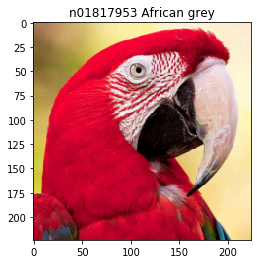

In [13]:
labels = open(os.path.join('/home/aminul/PyTorch_study/DeepFool/synset_words.txt'), 'r').read().split('\n')

str_label_orig = labels[np.int(label_orig)].split(',')[0]
str_label_pert = labels[np.int(label_pert)].split(',')[0]

print("Original label = ", str_label_orig)
print("Perturbed label = ", str_label_pert)

pert_image_numpy = pert_image.detach().squeeze().numpy()
print(pert_image_numpy.shape)
plt.figure()
plt.imshow(pert_image_numpy.transpose(1,2,0))
plt.title(str_label_pert)
plt.show()

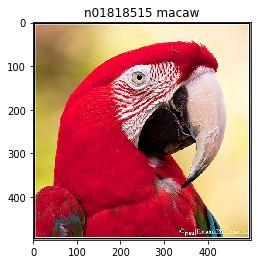

In [14]:
plt.figure()
plt.imshow(im_orig)
plt.title(str_label_orig)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


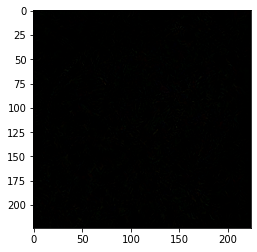

In [15]:
r_new = r.squeeze()

plt.figure()
plt.imshow(r_new.transpose(1,2,0))
plt.show()